## Adding root directory to system-path

In [1]:
import os
import sys

app_path = os.getcwd().rsplit(os.sep, 1)[0]

if app_path not in sys.path:
    sys.path.insert(0, app_path)

# 0. Imports

In [27]:
import math
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from geopy.distance import great_circle
from utils.paths import raw_data_path, inter_data_path
from utils.helpers import *

"""
DEPENDENCIES:
    - pandas
    - numpy
    - geopy
"""

'\nDEPENDENCIES:\n    - pandas\n    - numpy\n    - geopy\n'

In [3]:
path = raw_data_path('train.csv')
# path = inter_data_path('ash_df.csv')
# path = inter_data_path('train.csv')
df   = pd.read_csv(path)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,5728806,Large private room in Nolita,4271676,Nat,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,2015-09-01,0.06,3,0
1,2243769,Super Bowl New York City Apartment,11460768,Brian,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
2,35515415,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,267193767,Jenny,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,2019-07-05,4.00,1,365
3,36202006,Stream-Pressed Paradise (Laundry Room Setup),43392243,Rita,Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
4,3780951,Charming Harlem apartment,16065171,Gina,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,2019-05-26,0.27,1,365


In [4]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.422600e+04,3.422600e+04,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,27244.000000,34226.000000,34226.000000
mean,1.898209e+07,6.733847e+07,40.729059,-73.952070,153.480979,6.953690,23.390931,1.377074,7.093905,113.301730
std,1.097597e+07,7.833091e+07,0.054604,0.046161,243.312608,20.255833,44.476822,1.688953,32.828412,131.892814
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.460366e+06,7.824440e+06,40.690040,-73.983150,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.965371e+07,3.065628e+07,40.722995,-73.955700,107.000000,2.000000,5.000000,0.730000,1.000000,45.000000
75%,2.908201e+07,1.074344e+08,40.763200,-73.935982,175.000000,5.000000,24.000000,2.020000,2.000000,229.000000
max,3.648724e+07,2.743115e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
df.shape

(34226, 16)

# 1. Renaming calculated_host_listings_count to listing_per_host

In [6]:
df.rename(columns={'calculated_host_listings_count': 'listing_per_host'}, inplace=True)

# 2. Transforming last-review from datetime to no-of-days with timdelta of latest review with each review

In [7]:

def transform_last_review(df: pd.DataFrame) -> pd.DataFrame:
    """Transforms last_review column from datetime obj to no of days from latest review -> int"""

    try:
        df['last_review']

    except TypeError:
        print(" NO last_review COLUMN FOUND")
        return
    
    lastest_review = datetime.strptime(df.last_review.sort_values(ascending=False).iloc[0], "%Y-%m-%d")

    def get_timedelta(reference: str, origin=lastest_review) -> int:
        reference = datetime.strptime(reference, "%Y-%m-%d")
        delta = origin - reference
        return delta.days

    last_review_days = []

    for review in df.last_review:
        last_review_days.append(get_timedelta(review))

    df['last_review'] = last_review_days
    return df

### Note: Missing last-review dates to be filled with an arbitrary date, before transforming (Here: '2001-01-01').

In [8]:
df.last_review = df.last_review.fillna('2001-01-01')

df = transform_last_review(df)

In [9]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,listing_per_host,availability_365
0,5728806,Large private room in Nolita,4271676,Nat,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,1406,0.06,3,0
1,2243769,Super Bowl New York City Apartment,11460768,Brian,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,6762,NaN,1,0
2,35515415,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,267193767,Jenny,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,3,4.00,1,365
3,36202006,Stream-Pressed Paradise (Laundry Room Setup),43392243,Rita,Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,6762,NaN,4,82
4,3780951,Charming Harlem apartment,16065171,Gina,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,43,0.27,1,365


# 3. Calculate distance from centre of NYC and eliminate lattitude and longitude

In [10]:
def create_radius_feature(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates distance of each listing with the centre of NYC. stored in radius column"""

    try:
        lat_lon = df[['latitude', 'longitude']]

    except TypeError:
        print(" NO latitue or longitude COLUMN FOUND ")
        return

    def get_radius(lat, lon):
        nyc_centre    = (74.0060, 40.7128)
        accommodation = (lat, lon)
        return great_circle(nyc_centre, accommodation).km

    radii = []

    for value in lat_lon.values:
        dist = get_radius(value[0], value[1])
        radii.append(round(dist, 3))

    df['radius'] = radii
    
    return df

In [11]:
df = create_radius_feature(df)

In [12]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,listing_per_host,availability_365,radius
0,5728806,Large private room in Nolita,4271676,Nat,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,1406,0.06,3,0,6374.418
1,2243769,Super Bowl New York City Apartment,11460768,Brian,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,6762,NaN,1,0,6365.273
2,35515415,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,267193767,Jenny,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,3,4.00,1,365,6368.323
3,36202006,Stream-Pressed Paradise (Laundry Room Setup),43392243,Rita,Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,6762,NaN,4,82,6389.364
4,3780951,Charming Harlem apartment,16065171,Gina,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,43,0.27,1,365,6363.764


# 4. Dropping Unwanted columns

In [13]:
unwanted_cols = ['id', 'host_id', 'name', 'host_name', 'latitude', 'longitude', 'neighbourhood', 'reviews_per_month']

df = df.drop(unwanted_cols, 1)

# 5. Filling NaN values

In [14]:
missing_values_counts(df)

neighbourhood_group    0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
last_review            0
listing_per_host       0
availability_365       0
radius                 0
dtype: int64

### Replacing missing reviews-per-month with mean reviews per month 


In [15]:
# mean_rpm = df.reviews_per_month.mean()
# df.reviews_per_month = df.reviews_per_month.fillna(mean_rpm)

In [16]:
missing_values_counts(df)

neighbourhood_group    0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
last_review            0
listing_per_host       0
availability_365       0
radius                 0
dtype: int64

# 6. Handling Categorical features

In [17]:
get_categorical_df(df).head()

,neighbourhood_group,room_type
0,Manhattan,Private room
1,Manhattan,Entire home/apt
2,Queens,Entire home/apt
3,Staten Island,Shared room
4,Manhattan,Shared room


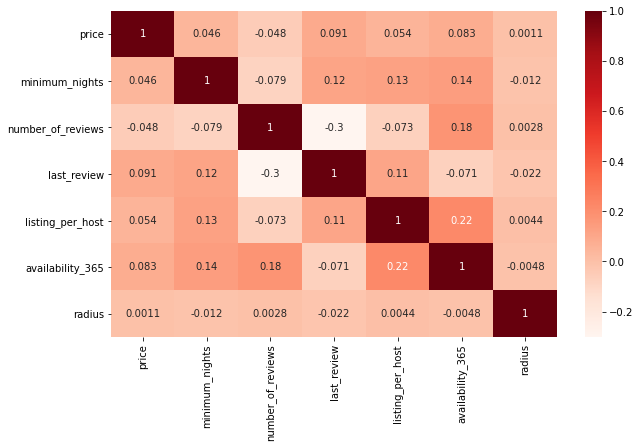

In [18]:
corr = df.corr()
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot=True,cmap=plt.cm.Reds)

### One-Hot Encoding room_type

In [19]:
one_hot_cols = ['room_type', 'neighbourhood_group']
df = one_hot_encode(df, one_hot_cols)


In [20]:
df.head()

,price,minimum_nights,number_of_reviews,last_review,listing_per_host,availability_365,radius,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,120,7,3,1406,3,0,6374.418,0,1,0,0,0,1,0,0
1,1500,1,0,6762,1,0,6365.273,1,0,0,0,0,1,0,0
2,200,2,4,3,1,365,6368.323,1,0,0,0,0,0,1,0
3,30,2,0,6762,4,82,6389.364,0,0,1,0,0,0,0,1
4,115,1,16,43,1,365,6363.764,0,0,1,0,0,1,0,0


In [21]:
X = df.drop(['price'], 1)
y = df.price

result = run_regression_models(X, y, None)

Linear Regression : 0.10399580235807726
Ridge : 0.10400964914728295
Lasso : 0.10389040937815319


## Saving data to intermediate data

In [22]:
# df.to_csv(inter_data_path('clean_unscaled.csv'))

## Saving model

In [23]:
def get_best_model(results: list):
    """Resturns best model with lowest RMSE score"""
    score = math.inf
    best_model = None

    for result in results:

        if result['score'] < score:
            score = result['score']
            best_model = result['model']
    
    print("Best model is {} \nwith RMSE score: {}".format(best_model, score))
    return {'model': best_model, 'score': score}


In [24]:
# {'model': model, 'score': score}
# model_scores = result.values()
best_model = get_best_model(result.values())

Best model is Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 
with RMSE score: 0.10389040937815319


In [28]:

storage_path()

NameError: name 'storage_path' is not defined

In [31]:
import pickle

with open(, 'w') as obj_file:
    pickle.dump(best_model, obj_file)

TypeError: write() argument must be str, not bytes

# Transforming test-data